# Brainwash Visualize

- read in JSON boxes
- read in one image to get size
- draw bboxes in b/w

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
import math
from glob import glob
from random import randint
import json
from pprint import pprint

import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from pathlib import Path
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import file_utils, im_utils
from app.models.bbox import BBox

In [2]:
fp_dir_ims = '/data_store_hdd/datasets/people/brainwash/dataset/brainwash/images/'
fp_out_mean = '/data_store_hdd/datasets/people/brainwash/processed/brainwash_mean.png'
fp_out_mean_bboxes = '/data_store_hdd/datasets/people/brainwash/processed/brainwash_mean_bboxes.png'
fp_json_test = '/data_store_hdd/datasets/people/brainwash/dataset/brainwash/test_boxes.json'
fp_json_train = '/data_store_hdd/datasets/people/brainwash/dataset/brainwash/train_boxes.json'
fp_json_val = '/data_store_hdd/datasets/people/brainwash/dataset/brainwash/val_boxes.json'

In [3]:
# function to create spaced colormaps as RGB values

import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import cm

def get_color_map(cmap='prism', ncolors=20, as_hex=False, reverse=False, bgr=True):
  norm  = mpl.colors.Normalize(vmin=0, vmax=ncolors-1)
  scalars = mplcm.ScalarMappable(norm=norm, cmap=cmap)
  colors = [scalars.to_rgba(i) for i in range(ncolors)]
  colors = [(int(255*c[0]),int(255*c[1]),int(255*c[2])) for c in colors]  
  if reverse:
    colors = colors[::-1]
  if bgr:
    colors = [c[::-1] for c in colors]
  if as_hex:
    colors = ['#{:02x}{:02x}{:02x}'.format(c[0],c[1],c[2]) for c in colors]
  return colors

def jit(x, amt=.01, prob=0.25):
  # jitter a xy point
  r = random.random()
  if r < prob:
    if r < (prob/2.0):
      return x + (random.random() * amt)
    else:
      return x - (random.random() * amt)
  else:
    return x
  
def jitter_clr(clr, amt=10, mono=False):
  clr = list(clr)
  if mono:
    r = randint(-amt, amt)
    for i in range(len(clr)):
      clr[i] = max(0, min(255, clr[i] + r))
  else:
    for i in range(len(clr)):
      r = randint(-amt, amt)
      clr[i] = max(0, min(255, clr[i] + r))
  return clr

def random_color():
  return tuple(map(int, np.random.choice(range(256), size=3)))

## Create averaged image

In [4]:
use_existing = True

if use_existing:
  # load average image
  im_mean = cv.imread(fp_out_mean)
  print('loaded image')
else:
  # or create
  fp_ims = glob(join(fp_dir_ims, '*.png'))
  print(len(fp_ims))

  ims = []
  for fp_im in fp_ims:
    ims.append(cv.imread(fp_im))

  im_mean = np.mean(ims, axis=0).astype(np.uint8)
  cv.imwrite(fp_out_mean, im_mean)
  print('wrote image')

loaded image


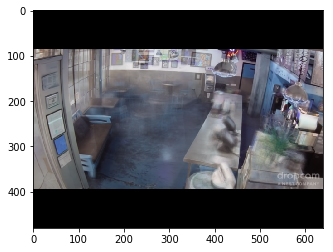

In [5]:
plt.imshow(im_mean)

## Draw BBoxes

In [6]:
im_mean_copy = im_mean.copy()

In [7]:
bboxes_test = file_utils.load_json(fp_json_test)
bboxes_train = file_utils.load_json(fp_json_train)
bboxes_val = file_utils.load_json(fp_json_val)
bboxes_all = bboxes_val + bboxes_test + bboxes_train

In [8]:
print(len(bboxes_all))

11769


In [9]:
pprint(bboxes_all[0])

{'image_path': 'brainwash_11_24_2014_images/06966500_640x480.png',
 'rects': [{'x1': 182.0, 'x2': 197.0, 'y1': 138.0, 'y2': 156.0},
           {'x1': 160.0, 'x2': 177.0, 'y1': 153.0, 'y2': 175.0},
           {'x1': 128.0, 'x2': 147.0, 'y1': 168.0, 'y2': 190.0},
           {'x1': 195.0, 'x2': 241.0, 'y1': 221.0, 'y2': 271.0},
           {'x1': 249.0, 'x2': 271.0, 'y1': 159.0, 'y2': 183.0},
           {'x1': 334.0, 'x2': 350.0, 'y1': 136.0, 'y2': 154.0},
           {'x1': 424.0, 'x2': 446.0, 'y1': 135.0, 'y2': 156.0},
           {'x1': 474.0, 'x2': 494.0, 'y1': 150.0, 'y2': 169.0},
           {'x1': 520.0, 'x2': 540.0, 'y1': 173.0, 'y2': 199.0}]}


In [10]:
bboxes = []
#bboxes_jit = []
dim = (640,480)
for bbox in bboxes_all:
  for rect in bbox['rects']:
      b = BBox.from_xyxy_dim(rect['x1'], rect['y1'], rect['x2'], rect['y2'], dim)
      if b.width > .25 or b.height > .25:
        print(b)
      bboxes.append(BBox.from_xyxy_dim(rect['x1'], rect['y1'], rect['x2'], rect['y2'], dim))
      #bboxes_jit.append(BBox.from_xyxy_dim(jit(rect['x1']), jit(rect['y1']), jit(rect['x2']), jit(rect['y2']), dim))

BBox: (0.3375,0.33125), (0.39375, 0.5854166666666667), width:0.05624999999999997, height:0.2541666666666667


In [11]:
# random shuffle bboxes
#bboxes_rand = bboxes_jit.copy()
#random.shuffle(bboxes_rand)

In [12]:
print(bboxes[0])
bbox = bboxes[0]

BBox: (0.284375,0.2875), (0.3078125, 0.325), width:0.0234375, height:0.03750000000000003


## Create Saliency Heat Map

In [218]:
im_saliency = np.zeros([dim[1], dim[0]]).astype(np.float32)
for i, bbox in enumerate(tqdm(bboxes)):
  bbox = bbox.to_dim(dim)
  pt1, pt2 = tuple(map(int, bbox.pt_tl)), tuple(map(int, bbox.pt_br))
  im_saliency[pt1[1]:pt2[1], pt1[0]:pt2[0]] += 1

In [551]:
im_saliency_mean = (im_saliency /  (np.max(im_saliency) / 3 )).astype(np.float32)
im_saliency_mean = 255 * im_saliency_mean
im_saliency_mean = np.clip(im_saliency_mean, 0, 255).astype(np.uint8)
im_saliency_mean = cv.blur(im_saliency_mean, ksize=(13, 13))

im_saliency_mean_bgr = cv.cvtColor(im_saliency_mean, cv.COLOR_GRAY2BGR)
im_cm = cv.applyColorMap(im_saliency_mean, cv.COLORMAP_JET)

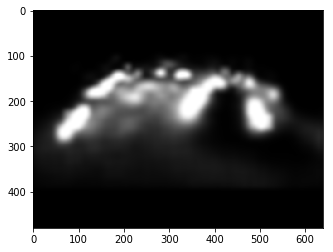

In [552]:
plt.imshow(im_saliency_mean_bgr)

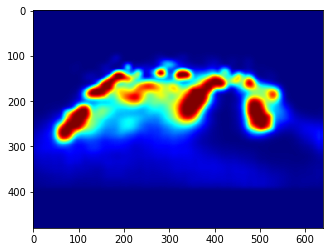

In [553]:
plt.imshow(cv.cvtColor((im_cm).astype(np.uint8), cv.COLOR_BGR2RGB))

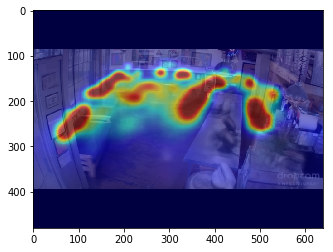

In [554]:
# preview overlay (not for production)
alpha = 0.5
im_comp = cv.addWeighted(im_mean, alpha, im_cm, 1 - alpha, 0)
plt.imshow(cv.cvtColor(im_comp, cv.COLOR_BGR2RGB))

In [555]:
import blend_modes

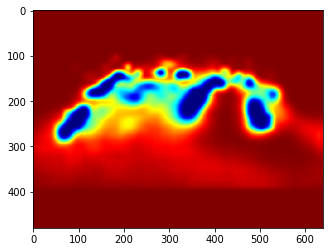

In [556]:
plt.imshow(im_cm)

In [672]:
im_dark = np.ones_like(im_mean) * np.array([.05])
im_mean_dark = cv.addWeighted(im_mean, 0.9, im_dark, 0.3, 0)

In [673]:
im_mean_bgra = cv.cvtColor(im_mean_dark.astype(np.float32), cv.COLOR_BGR2BGRA)
im_cm_bgra = cv.cvtColor(im_cm_test_blur.astype(np.float32), cv.COLOR_BGR2BGRA)

In [674]:
# Blend images
opacity = 1  # The opacity of the foreground that is blended onto the background is 70 %.
#blended_img_float = blend_modes.screen(im_mean_bgra, im_cm_bgra, opacity)
blended_img_float = blend_modes.dodge(im_mean_bgra, im_cm_bgra, opacity)
blended_img_float = blend_modes.overlay(blended_img_float.copy(), im_cm_bgra, opacity)

In [675]:
blended_img = blended_img_float.astype(np.uint8)

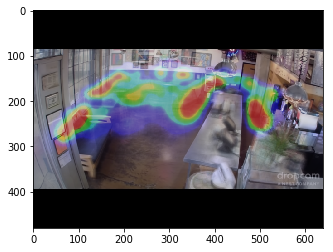

In [676]:
blended_img = cv.cvtColor(blended_img, cv.COLOR_BGRA2BGR)
cv.imwrite('/home/adam/Downloads/test.png', blended_img)
plt.imshow(cv.cvtColor(blended_img, cv.COLOR_BGR2RGB))

In [312]:
cv.imwrite('/data_store/datasets/people/brainwash/processed/brainwash_saliency.png', image_cm)
cv.imwrite('/data_store/datasets/people/brainwash/processed/brainwash_saliency_bw.png', im_saliency_mean)

True

## Old Version

In [86]:
size_orig = (640, 480)
scale = 2
size_draw = (int(size_orig[0] * scale), int(size_orig[1] * scale))

In [90]:
im_mean_lg = im_utils.resize(im_mean, width=size_draw[0])

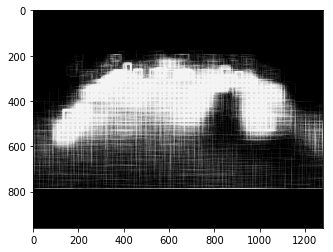

In [185]:
# draw it
clr = (255,255,255)
im_draw = np.zeros([size_draw[1], size_draw[0], 3]).astype(np.uint8)
im_bg = im_draw.copy()
limit = 1000000
stroke_weight = 1
alpha = 0.05
w,h = size_scale
for i, bbox in enumerate(tqdm(bboxes_rand)):
  bbox = bbox.to_dim(size_draw)
  pt1, pt2 = tuple(map(int, bbox.pt_tl)), tuple(map(int, bbox.pt_br))
  im_draw_next = im_bg.copy()
  cv.rectangle(im_draw_next, pt1, pt2, clr, stroke_weight, cv.LINE_AA)
  im_bg = cv.addWeighted(im_draw_next, alpha, im_bg, 1 - alpha, 0)
  if i > limit:
    break

plt.imshow(cv.cvtColor(im_bg, cv.COLOR_BGR2RGB))

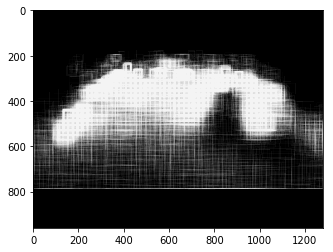

In [186]:
plt.imshow(cv.cvtColor(im_draw_next, cv.COLOR_BGR2RGB))

In [187]:
cv.imwrite(fp_out_mean_bboxes, im_bg)

True

In [ ]:
cv.im